## Use MELD to identify clusters containing distinct cell states for vertex frequency clustering.

#### Load libraries and set input/output paths for local and cluster environments. Need to select starting cluster assignment based on inspection of spectral clustering plots generated previously.

In [1]:
import os
import sklearn
import pickle
import pandas as pd
import numpy as np
import graphtools as gt
import phate
import magic
import scprep
import scanpy as sc
import anndata as ad
import meld
print(meld.version)
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import spearmanr

np.random.seed(42)
font = {'size'   : 14}
mpl.rc('font', **font)

if os.path.isdir('/Users/mac/cloudstor/') == True:
    place = 'local'
    indir = '/Users/mac/cloudstor/sarah_projects/SCMDA231mets_chrcha/project_results/prefiltering/practice_all_data/'
    outdir = '/Users/mac/cloudstor/sarah_projects/SCMDA231mets_chrcha/project_results/meld/practice_all_data/'
    dataset = 'practice'
else:
    place = 'wolfpack'
    indir = '/share/ScratchGeneral/scoyou/sarah_projects/SCMDA231mets_chrcha/project_results/prefiltering/all_data/'
    outdir = '/share/ScratchGeneral/scoyou/sarah_projects/SCMDA231mets_chrcha/project_results/meld/all_data/'
    dataset = 'all'

print('Place: ', place,
       'indir: ', indir,
       'outdir: ', outdir)

cmaps = pickle.load(open(os.path.join(outdir, 'MELD_cmaps.pkl'), "rb" ) )
sc.settings.autosave = True
sc.settings.figdir = outdir

<module 'meld.version' from '/Users/mac/.local/lib/python3.7/site-packages/meld/version.py'>
Place:  local indir:  /Users/mac/cloudstor/sarah_projects/SCMDA231mets_chrcha/project_results/prefiltering/practice_all_data/ outdir:  /Users/mac/cloudstor/sarah_projects/SCMDA231mets_chrcha/project_results/meld/practice_all_data/


#### Select starting cluster assignment based on kmeans

Load sdata.obs object containing initial clustering assignments. Starting cluster assignment chosen based on visual inspection across a variety of K. **Need to select starting cluster assignment**

In [2]:
sdata = ad.read_h5ad(os.path.join(outdir, 'Prefiltered_experiment_' + str(dataset) + '_normalised_AnnData_PHATE_MAGIC_spectral_leiden.h5ad'))

In [3]:
sdata.obs['Start_cluster'] = sdata.obs['leiden']
sdata.obs['Start_cluster'] = sdata.obs['Start_cluster'].astype(str)

/Users/mac/.local/lib/python3.7/site-packages/scprep/select.py:381: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/Users/mac/.local/lib/python3.7/site-packages/scprep/utils.py:199: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/Users/mac/.local/lib/python3.7/site-packages/scprep/utils.py:201: FutureWarning: The SparseSeries class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(x, pd.SparseSeries):


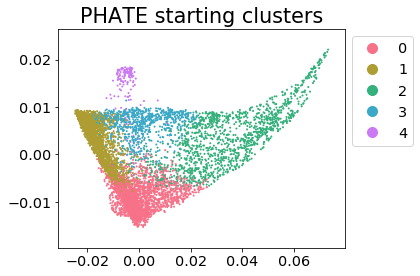

In [4]:
clusters = sdata.obs['Start_cluster'].values.astype('int')
ax = scprep.plot.scatter2d(sdata.obsm['X_phate_harmony'], c=clusters, cmap=sns.husl_palette(5), s=1,
                           legend_anchor=(1,1), fontsize=12, title='PHATE starting clusters')
fig = ax.figure
fig.savefig(os.path.join(outdir, 'PHATE_starting_clusters.png'), dpi=300)

#### Use MELD to calculate an enhanced experimental signal based on Graph density. Graph has already been computed. May require changing beta (smoothing) parameter when using whole experiment.

In [5]:
G = pickle.load(open(os.path.join(outdir, 'Prefiltered_experiment_' + str(dataset) + '_Harmonised_GRAPH.pkl'), "rb" ) )

Create MELD operator

In [6]:
if place == 'local':
    meld_op = meld.MELD()
else:
    meld_op = meld.MELD(beta = 150)

Calculate EES (unnormalised)

In [7]:
EES_sample = meld_op.fit_transform(G, RES=sdata.obs['Sample'])
EES_sample.index = sdata.obs.index
EES_sample = EES_sample[list(cmaps['sample_cmap'])]

Building graph on 7055 samples and 100 features.


/Users/mac/.local/lib/python3.7/site-packages/scprep/utils.py:199: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/Users/mac/.local/lib/python3.7/site-packages/scprep/utils.py:201: FutureWarning: The SparseSeries class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(x, pd.SparseSeries):
/Users/mac/.local/lib/python3.7/site-packages/scprep/utils.py:199: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/Users/mac/.local/lib/python3.7/site-packages/scprep/utils.py:201: FutureWarning: The SparseSeries class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(x, pd.Spa

Function to normalise EES across replicates (cell number)

In [8]:
def replicate_normalize_EES(EES, replicate):
    replicates = np.unique(replicate)
    EES_norm = EES.copy()
    for rep in replicates:
        curr_cols = EES.columns[[col.endswith(rep) for col in EES.columns]]
        EES_norm[curr_cols] = sklearn.preprocessing.normalize(EES[curr_cols], norm='l1')
    return EES_norm

In [9]:
EES_norm = replicate_normalize_EES(EES_sample, sdata.obs['Replicate'])

Calculate and normalise RES (cell number)

In [10]:
LB = sklearn.preprocessing.LabelBinarizer()
RES_tissue = LB.fit_transform(sdata.obs['Tissue'])
RES_tissue = RES_tissue / RES_tissue.sum(axis=0)
RES_tissue = pd.DataFrame(RES_tissue, columns=['LN', 'Liver', 'Lung', 'Primary'], index=sdata.obs.index)[list(cmaps['tissue_cmap'])]
RES_tissue

,Primary,LN,Liver,Lung
1_AAACCTGCATTGTGCA-1,0.000000,0.0,0.000506,0.0
1_AAACCTGGTGTGACGA-1,0.000000,0.0,0.000506,0.0
1_AAACGGGGTCGTCTTC-1,0.000000,0.0,0.000506,0.0
1_AAAGTAGCATGGGACA-1,0.000000,0.0,0.000506,0.0
1_AAAGTAGTCGTCTGAA-1,0.000000,0.0,0.000506,0.0
...,...,...,...,...
19_TTTATGCTCTTGTATC-1,0.000683,0.0,0.000000,0.0
19_TTTGCGCAGCAACGGT-1,0.000683,0.0,0.000000,0.0
19_TTTGCGCTCGTCTGAA-1,0.000683,0.0,0.000000,0.0
19_TTTGGTTCAGCTGTAT-1,0.000683,0.0,0.000000,0.0


In [11]:
pickle.dump(RES_tissue, open(os.path.join(outdir, 'Prefiltered_experiment_' + str(dataset) + '_Harmonised_MELD_RES.pkl'), "wb"), protocol=4)

RES_tissue.to_csv(os.path.join(outdir, 'Prefiltered_experiment_' + str(dataset) + '_Harmonised_MELD_RES.csv'), index = True, header = True)

Calculate mean normalised EES across replicates for each tissue

In [12]:
EES_tissue = pd.DataFrame({'Primary':EES_norm[['Primary_1', 'Primary_2', 'Primary_3', 'Primary_4']].mean(axis=1)})
EES_tissue['LN'] = pd.DataFrame(EES_norm[['LN_1', 'LN_2', 'LN_3', 'LN_4']].mean(axis=1))
EES_tissue['Liver'] = pd.DataFrame(EES_norm[['Liver_1', 'Liver_2', 'Liver_3', 'Liver_4']].mean(axis=1))
EES_tissue['Lung'] = pd.DataFrame(EES_norm[['Lung_1', 'Lung_2', 'Lung_3', 'Lung_4']].mean(axis=1))
EES_tissue

,Primary,LN,Liver,Lung
1_AAACCTGCATTGTGCA-1,0.184012,0.280854,0.465476,0.069658
1_AAACCTGGTGTGACGA-1,0.207103,0.224905,0.447684,0.120308
1_AAACGGGGTCGTCTTC-1,0.153040,0.271895,0.409934,0.165131
1_AAAGTAGCATGGGACA-1,0.094414,0.152164,0.406172,0.347250
1_AAAGTAGTCGTCTGAA-1,0.200389,0.256065,0.377117,0.166428
...,...,...,...,...
19_TTTATGCTCTTGTATC-1,0.490546,0.213685,0.119040,0.176728
19_TTTGCGCAGCAACGGT-1,0.480294,0.147517,0.293743,0.078446
19_TTTGCGCTCGTCTGAA-1,0.271911,0.268421,0.341486,0.118182
19_TTTGGTTCAGCTGTAT-1,0.342515,0.227071,0.123675,0.306739


In [13]:
pickle.dump(EES_tissue, open(os.path.join(outdir, 'Prefiltered_experiment_' + str(dataset) + '_Harmonised_MELD_EES.pkl'), "wb"))

EES_tissue.to_csv(os.path.join(outdir, 'Prefiltered_experiment_' + str(dataset) + '_Harmonised_MELD_EES.csv'), index = True, header = True)

Visualise EES on PHATE embeddings

/Users/mac/.local/lib/python3.7/site-packages/scprep/select.py:381: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/Users/mac/.local/lib/python3.7/site-packages/scprep/utils.py:199: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/Users/mac/.local/lib/python3.7/site-packages/scprep/utils.py:201: FutureWarning: The SparseSeries class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(x, pd.SparseSeries):


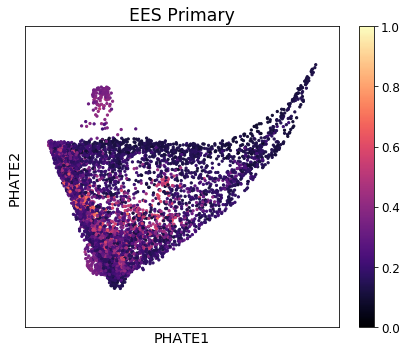

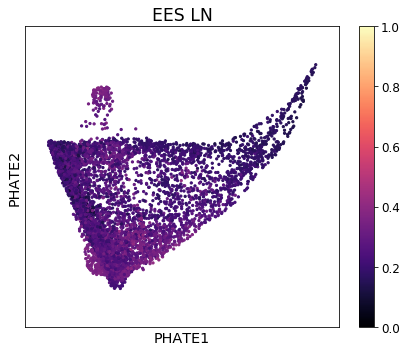

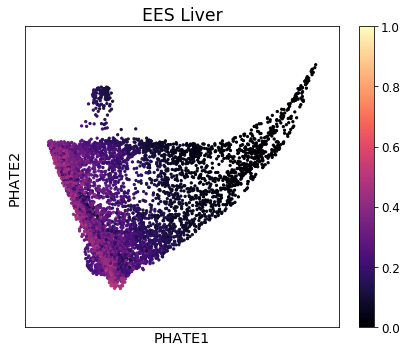

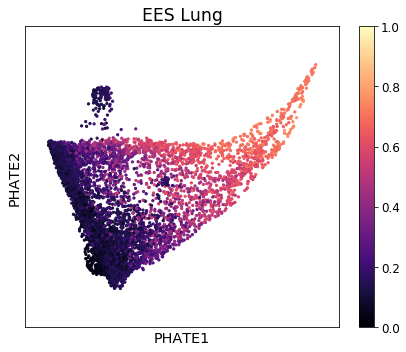

In [14]:
for tiss in list(cmaps['tissue_cmap']):
    ax = scprep.plot.scatter2d(sdata.obsm["X_phate_harmony"], c=EES_tissue[tiss], cmap='magma', vmin=0, vmax=1, figsize=(6,5), s=5, label_prefix='PHATE', ticks=False, title= 'EES ' + str(tiss))
    fig = ax.figure
    fig.savefig(os.path.join(outdir, 'PHATE_with_' + str(tiss) + '_EES.png'), dpi=300)

#### Visualise each EES distribution (each tissue) for each of the starting clusters. A big spread of values means cells from different states have been grouped together. Use this to identify clusters that need further refinement using Vertex Frequency Clustering (VFC). Important to consider what is random probability (ie 1 / # of conditions).

The large spread of EES in clusters 0 and 4 across a range of conditions indicate they contain distinct cell states and would benefit from further VFC.

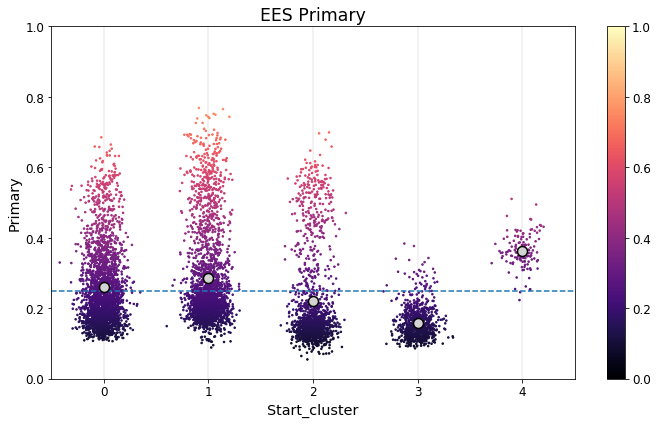

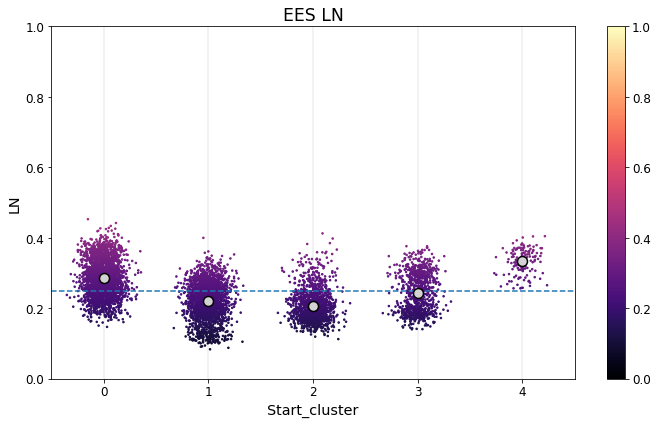

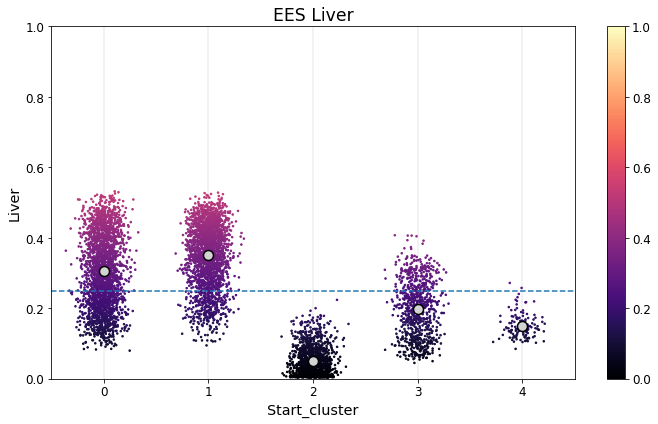

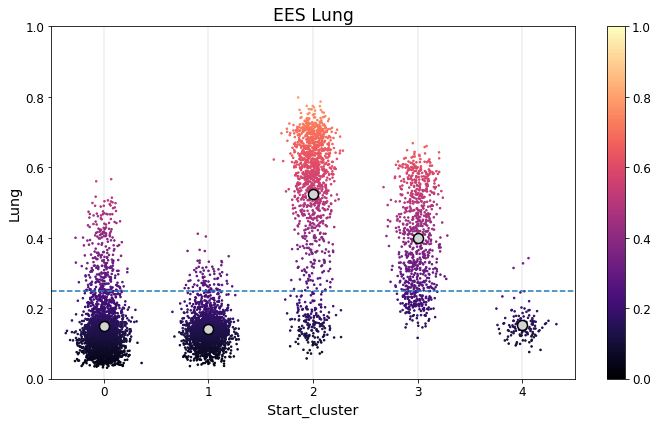

In [15]:
for tiss in list(cmaps['tissue_cmap']):
    ax = scprep.plot.jitter(sdata.obs['Start_cluster'], EES_tissue[tiss], c=EES_tissue[tiss],  cmap='magma', vmin=0, vmax=1, legend=True, figsize=(10,6), title= 'EES ' + str(tiss))
    ax.set_ylim(0,1)
    ax.axhline(0.25, ls='--')
    fig = ax.figure
    fig.tight_layout()
    fig.savefig(os.path.join(outdir, 'Jitter_with_' + str(tiss) + '_EES.png'), dpi=300)

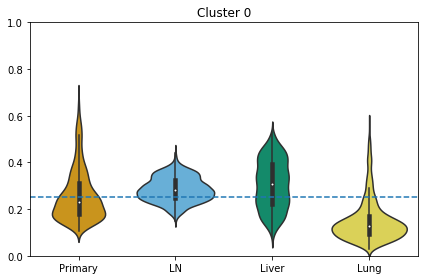

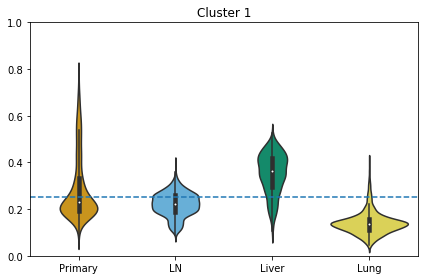

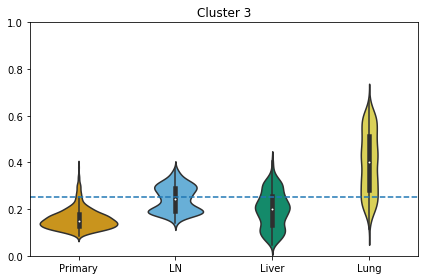

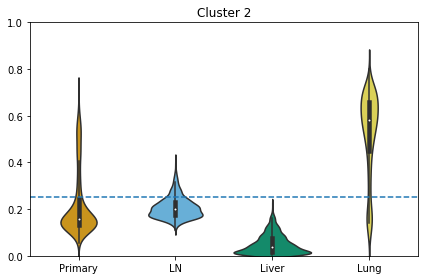

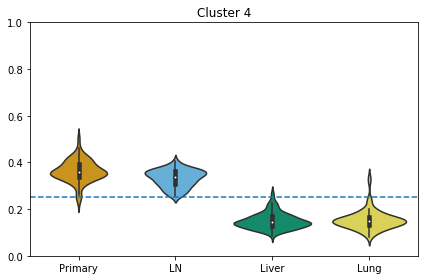

In [16]:
for curr_cluster in sdata.obs['Start_cluster'].unique():
    curr_ees = EES_tissue[sdata.obs['Start_cluster'] == curr_cluster]
    plt.figure()
    ax = sns.violinplot(data=curr_ees, palette=cmaps['tissue_cmap'])
    ax.set_title('Cluster ' + str(curr_cluster))
    ax.set_ylim(0,1)
    ax.axhline(0.25, ls='--')
    fig = ax.figure
    fig.tight_layout()
    fig.savefig(os.path.join(outdir, 'EES_violin_starting_cluster_' + str(curr_cluster) + '.png'), dpi=300)

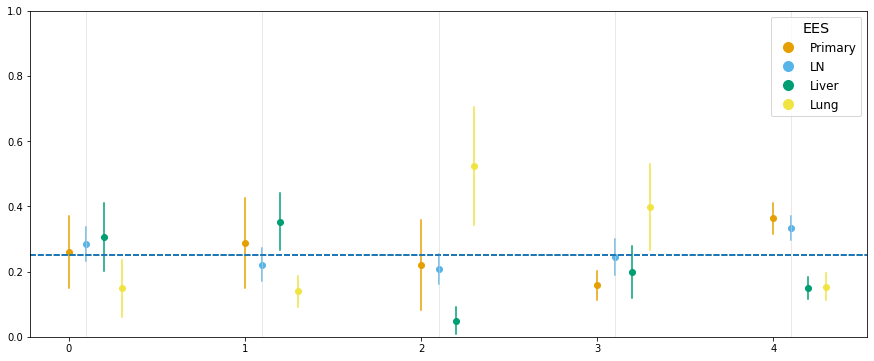

In [17]:
fig, ax = plt.subplots(1, figsize=(15,6))
tissue_cmap = cmaps['tissue_cmap']
for curr_cluster in sdata.obs['Start_cluster'].unique():

    curr_ees = EES_tissue[sdata.obs['Start_cluster'] == curr_cluster]
    curr_means = curr_ees.mean(axis=0)
    curr_std = curr_ees.std(axis=0)
    curr_cluster = int(curr_cluster)
    for i in range(4):
        ax.scatter(curr_cluster + (i * 0.1), curr_means[i], color=list(tissue_cmap.values())[i])
        ax.plot([curr_cluster + (i * 0.1), curr_cluster + (i * 0.1)], 
                [curr_means[i] - curr_std[i], curr_means[i] + curr_std[i]], color=list(tissue_cmap.values())[i])
    ax.set_ylim(0,1)
    ax.axhline(0.25, ls='--')
    ax.axvline(curr_cluster + 0.1, color='lightgrey', linewidth=0.5)
        
scprep.plot.tools.generate_legend(tissue_cmap, ax, title='EES')
fig.savefig(os.path.join(outdir, 'Dot-line_all_EES.png'), dpi=300)

#### Examine the relationship between EES scores in each cluster.

A function to add spearman correlation to seaborn.pairplot

In [18]:
def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top right hand corner of a plot."""
    r, _ = spearmanr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.7, .9), xycoords=ax.transAxes)

Plot pairwise comparison and correlation between samples

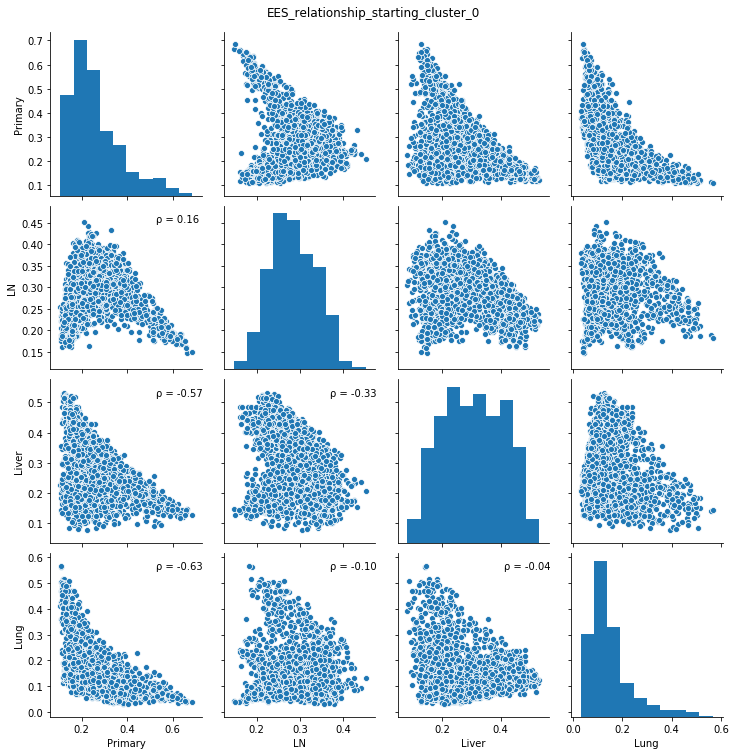

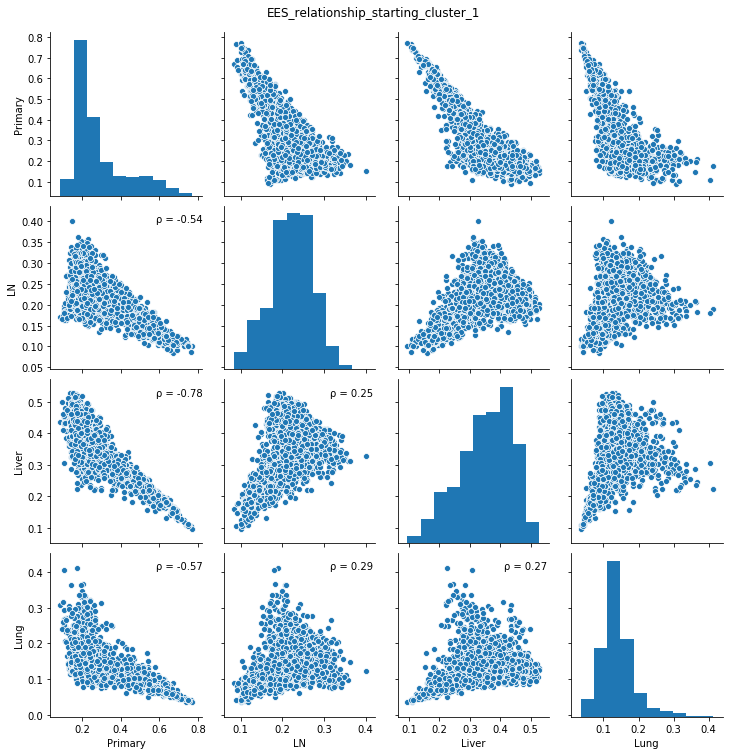

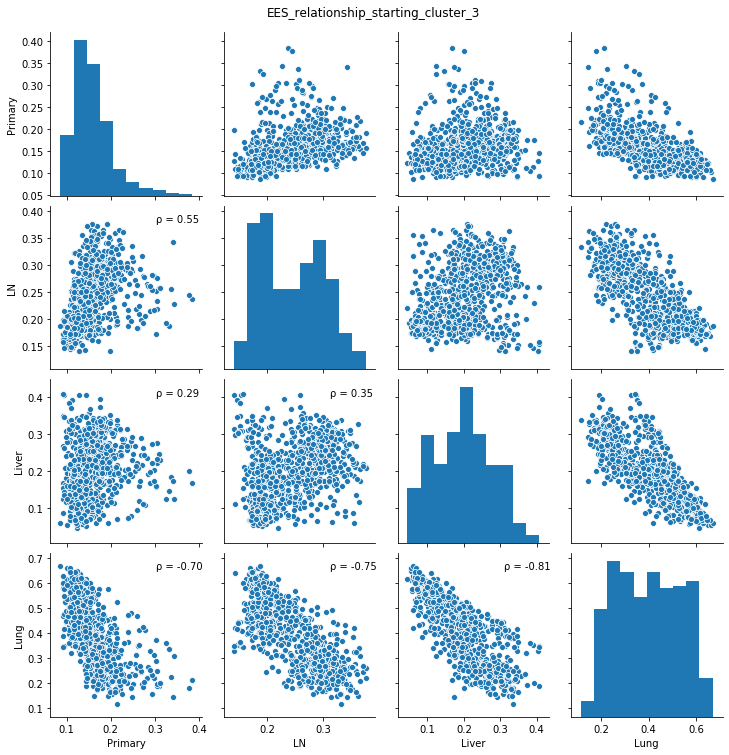

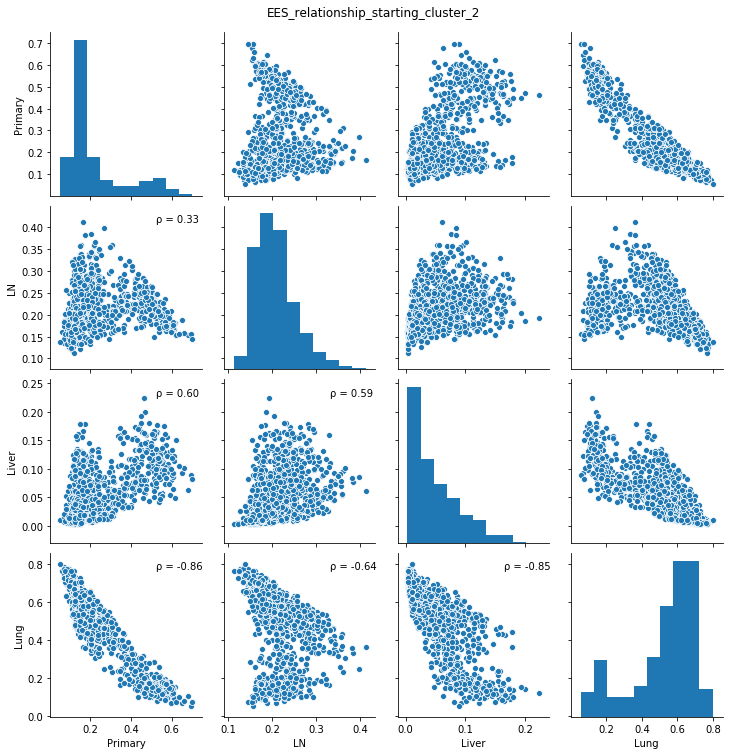

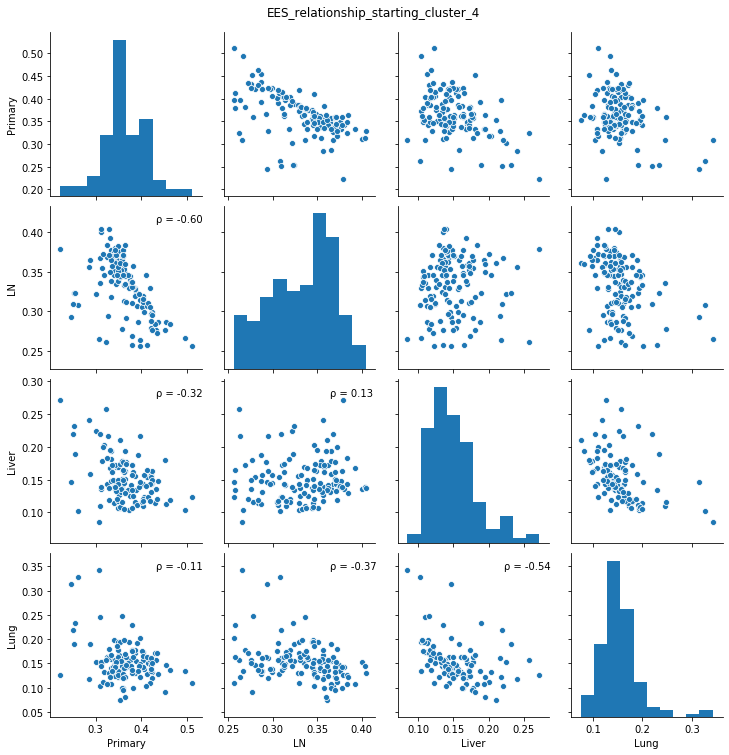

In [19]:
for clust in sdata.obs.Start_cluster.unique():
    EES_tmp = EES_tissue.loc[sdata.obs['Start_cluster'] == clust, ]
    ax = sns.pairplot(EES_tmp)
    ax.map_lower(corrfunc)
    ax.fig.suptitle('EES_relationship_starting_cluster_' + str(clust), y=1.03)
    ax.savefig(os.path.join(outdir, 'EES_relationship_starting_cluster_' + str(clust) + '.png'), dpi=300)

In [20]:
pickle.dump(sdata.obs, open(os.path.join(outdir, 'Prefiltered_experiment_' + str(dataset) + '_Harmonised_MELD_sdata.obs_starting_clusters.pkl'), "wb"), protocol=4)

sdata.obs.to_csv(os.path.join(outdir, 'Prefiltered_experiment_' + str(dataset) + '_Harmonised_MELD_sdata.obs_starting_clusters.csv'), index = True, header = True)